In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
etf50Risk = pd.read_pickle('data\option\etf50Risk.pkl')
etf300Risk = pd.read_pickle('data\option\etf300Risk.pkl')

In [3]:
atm50 = etf50Risk[(etf50Risk['is_at_the_money']==True)]
atm300 = etf300Risk[(etf300Risk['is_at_the_money']==True)]
atm50Call = atm50[(atm50['option_type']=='认购')]
atm50Put = atm50[(atm50['option_type']=='认沽')]
atm300Call = atm300[(atm300['option_type']=='认购')]
atm300Put = atm300[(atm300['option_type']=='认沽')]
atm50CallNxtSeason = atm50Call.groupby('datetime').apply(lambda x: x[x['maturity']==x['maturity'].max()])
atm50PutNxtSeason = atm50Put.groupby('datetime').apply(lambda x: x[x['maturity']==x['maturity'].max()])
atm300CallNxtSeason = atm300Call.groupby('datetime').apply(lambda x: x[x['maturity']==x['maturity'].max()])
atm300PutNxtSeason = atm300Put.groupby('datetime').apply(lambda x: x[x['maturity']==x['maturity'].max()])
atm50CallNxtSeason = atm50CallNxtSeason.reset_index(drop=True)
atm50PutNxtSeason = atm50PutNxtSeason.reset_index(drop=True)
atm300CallNxtSeason = atm300CallNxtSeason.reset_index(drop=True)
atm300PutNxtSeason = atm300PutNxtSeason.reset_index(drop=True)
atmCallNxtSeason = pd.merge(atm50CallNxtSeason, atm300CallNxtSeason, on=['datetime'], suffixes=('_50', '_300'))

In [4]:
# 计算分别atm50CallNxtSeason和atm300CallNxtSeason的iv的日变化
atmCallNxtSeason['iv_50_change'] = atmCallNxtSeason['iv_50'].pct_change()
atmCallNxtSeason['iv_300_change'] = atmCallNxtSeason['iv_300'].pct_change()
# 计算iv差值
atmCallNxtSeason['iv_diff'] = atmCallNxtSeason['iv_50'] - atmCallNxtSeason['iv_300']
# 计算iv差值的日变化
atmCallNxtSeason['iv_diff_change'] = atmCallNxtSeason['iv_diff'].diff()

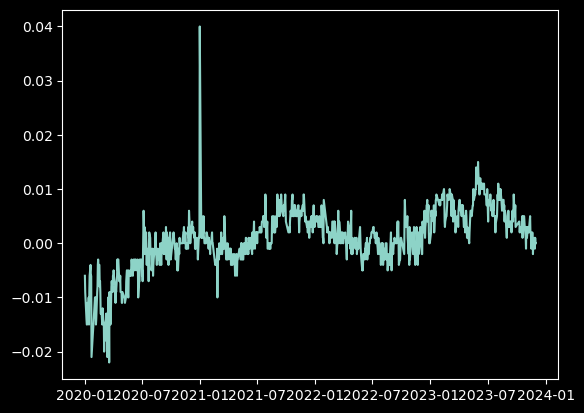

In [5]:
# 可视化iv差值走势
plt.plot(pd.to_datetime(atmCallNxtSeason['datetime']), atmCallNxtSeason['iv_diff'])
plt.show()

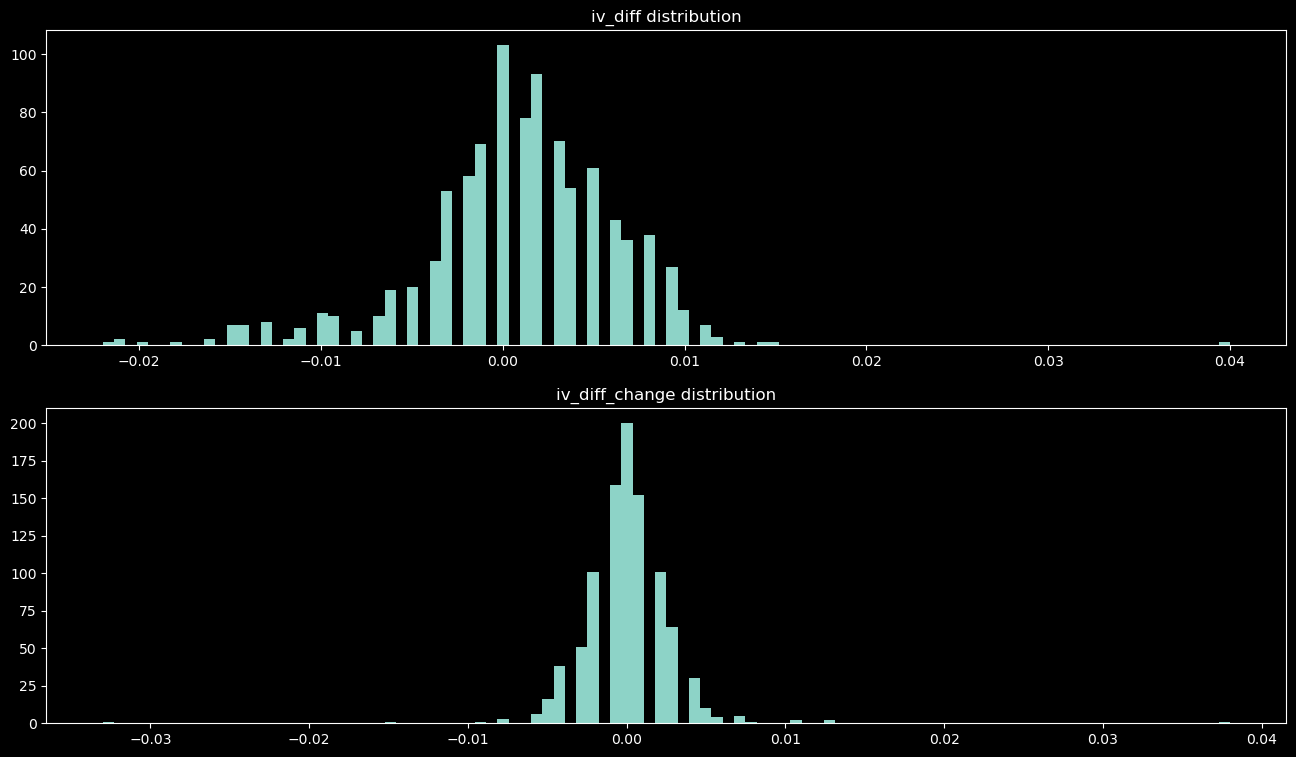

In [6]:
# 可视化iv差值分布
plt.figure(figsize=(16, 9))
plt.subplot(2, 1, 1)
plt.title('iv_diff distribution')
plt.hist(atmCallNxtSeason['iv_diff'], bins=100)
plt.subplot(2, 1, 2)
plt.title('iv_diff_change distribution')
plt.hist(atmCallNxtSeason['iv_diff_change'], bins=100)
plt.show()

In [7]:
ivdiffDown = atmCallNxtSeason[(atmCallNxtSeason['iv_diff_change']<0)]
ivdiffUp = atmCallNxtSeason[(atmCallNxtSeason['iv_diff_change']>0)]

## 探究分别iv_diff_change的信号

In [8]:
# 计算当前iv差值在10日内的10分位数和90分位数
atmCallNxtSeason['iv_diff_10pct'] = atmCallNxtSeason['iv_diff'].rolling(20).quantile(0.1)
atmCallNxtSeason['iv_diff_50pct'] = atmCallNxtSeason['iv_diff'].rolling(20).quantile(0.5)
atmCallNxtSeason['iv_diff_90pct'] = atmCallNxtSeason['iv_diff'].rolling(20).quantile(0.9)
# 计算iv_50在10日内的10分位数和90分位数
atmCallNxtSeason['iv_50_10pct'] = atmCallNxtSeason['iv_50'].rolling(10).quantile(0.2)
atmCallNxtSeason['iv_50_90pct'] = atmCallNxtSeason['iv_50'].rolling(10).quantile(0.8)
# 计算iv_300在10日内的10分位数和90分位数
atmCallNxtSeason['iv_300_10pct'] = atmCallNxtSeason['iv_300'].rolling(10).quantile(0.2)
atmCallNxtSeason['iv_300_90pct'] = atmCallNxtSeason['iv_300'].rolling(10).quantile(0.8)
# 将iv_diff_change向前移动一天
atmCallNxtSeason['iv_diff_change_shift'] = atmCallNxtSeason['iv_diff_change'].shift(-1)
# 将iv_50_change向前移动一天
atmCallNxtSeason['iv_50_change_shift'] = atmCallNxtSeason['iv_50_change'].shift(-1)
# 将iv_300_change向前移动一天
atmCallNxtSeason['iv_300_change_shift'] = atmCallNxtSeason['iv_300_change'].shift(-1)
# iv_diff大于90分位数的
ivdiffUp90 = atmCallNxtSeason[(atmCallNxtSeason['iv_diff']>atmCallNxtSeason['iv_diff_90pct'])]
# iv_diff小于10分位数的
ivdiffDown10 = atmCallNxtSeason[(atmCallNxtSeason['iv_diff']<atmCallNxtSeason['iv_diff_10pct'])]

## iv_diff突破90分位数

In [9]:
ivdiffUp90Iv = pd.DataFrame()
for date in ivdiffUp90['datetime'].to_list():
    inOptCode50 = ivdiffUp90.loc[ivdiffUp90['datetime']==date, 'optionCode_50'].to_list()[0]
    inOptCode300 = ivdiffUp90.loc[ivdiffUp90['datetime']==date, 'optionCode_300'].to_list()[0]
    inIv50 = ivdiffUp90.loc[ivdiffUp90['datetime']==date, 'iv_50'].to_list()[0]
    inIv300 = ivdiffUp90.loc[ivdiffUp90['datetime']==date, 'iv_300'].to_list()[0]

    outDate = atmCallNxtSeason.loc[(atmCallNxtSeason['iv_diff']<=atmCallNxtSeason['iv_diff_50pct'])&(atmCallNxtSeason['datetime']>=date) , 'datetime'].to_list()[0]
    outDate50 = etf50Risk.loc[(etf50Risk['datetime']<=outDate)&(etf50Risk['optionCode']==inOptCode50) , 'datetime'].to_list()[-1]
    outDate300 = etf300Risk.loc[(etf300Risk['datetime']<=outDate)&(etf300Risk['optionCode']==inOptCode300) , 'datetime'].to_list()[-1]
    outDate = min(outDate50, outDate300)

    outIv50 = etf50Risk.loc[(etf50Risk['datetime']==outDate)&(etf50Risk['optionCode']==inOptCode50) , 'iv'].to_list()[0]
    outIv300 = etf300Risk.loc[(etf300Risk['datetime']==outDate)&(etf300Risk['optionCode']==inOptCode300) , 'iv'].to_list()[0]

    ivdiffUp90Iv = pd.concat([ivdiffUp90Iv, pd.DataFrame({'inDate':[date],'outDate':[outDate],'OptCode50':[inOptCode50],'OptCode300':[inOptCode300],'inIv50':[inIv50],\
                                                          'outIv50':[outIv50],'inIv300':[inIv300],'outIv300':[outIv300]})], axis=0)

In [10]:
ivdiffUp90Iv['inIvDiff'] = ivdiffUp90Iv['inIv50'] - ivdiffUp90Iv['inIv300']
ivdiffUp90Iv['outIvDiff'] = ivdiffUp90Iv['outIv50'] - ivdiffUp90Iv['outIv300']
ivdiffUp90Iv['ioIvDiffChange'] = ivdiffUp90Iv['outIvDiff'] - ivdiffUp90Iv['inIvDiff']

In [11]:
# indiffUp90Iv中ioIvDiffChange小于0的比例
ivdiffUp90Iv[ivdiffUp90Iv['ioIvDiffChange']<0].shape[0]/ivdiffUp90Iv.shape[0]

0.8252427184466019

In [12]:
# ivdiffUp90Iv[ivdiffUp90Iv['ioIvDiffChange']<0]中Iv50下降，Iv300上升的比例
ivdiffUp90Iv[(ivdiffUp90Iv['ioIvDiffChange']<0)&(ivdiffUp90Iv['inIv50']>ivdiffUp90Iv['outIv50'])&(ivdiffUp90Iv['inIv300']<ivdiffUp90Iv['outIv300'])].shape[0]/ivdiffUp90Iv[ivdiffUp90Iv['ioIvDiffChange']<0].shape[0]

0.10588235294117647

In [13]:
# ivdiffUp90Iv[ivdiffUp90Iv['ioIvDiffChange']<0]中Iv50上升，Iv300上升的比例
ivdiffUp90Iv[(ivdiffUp90Iv['ioIvDiffChange']<0)&(ivdiffUp90Iv['inIv50']<ivdiffUp90Iv['outIv50'])&(ivdiffUp90Iv['inIv300']<ivdiffUp90Iv['outIv300'])].shape[0]/ivdiffUp90Iv[ivdiffUp90Iv['ioIvDiffChange']<0].shape[0]

0.3411764705882353

In [14]:
# ivdiffUp90Iv[ivdiffUp90Iv['ioIvDiffChange']<0]中Iv50下降，Iv300下降的比例
ivdiffUp90Iv[(ivdiffUp90Iv['ioIvDiffChange']<0)&(ivdiffUp90Iv['inIv50']>ivdiffUp90Iv['outIv50'])&(ivdiffUp90Iv['inIv300']>ivdiffUp90Iv['outIv300'])].shape[0]/ivdiffUp90Iv[ivdiffUp90Iv['ioIvDiffChange']<0].shape[0]

0.4117647058823529

In [15]:
# ivdiffUp90Iv[ivdiffUp90Iv['ioIvDiffChange']<0]中Iv50不变或者Iv300不变的比例
ivdiffUp90Iv[(ivdiffUp90Iv['ioIvDiffChange']<0)&((ivdiffUp90Iv['inIv50']==ivdiffUp90Iv['outIv50'])|(ivdiffUp90Iv['inIv300']==ivdiffUp90Iv['outIv300']))].shape[0]/ivdiffUp90Iv[ivdiffUp90Iv['ioIvDiffChange']<0].shape[0]

0.1411764705882353

## ivDiff突破10分位数

In [16]:
ivdiffDown10Iv = pd.DataFrame()
for date in ivdiffDown10['datetime'].to_list():
    inOptCode50 = ivdiffDown10.loc[ivdiffDown10['datetime']==date, 'optionCode_50'].to_list()[0]
    inOptCode300 = ivdiffDown10.loc[ivdiffDown10['datetime']==date, 'optionCode_300'].to_list()[0]
    inIv50 = ivdiffDown10.loc[ivdiffDown10['datetime']==date, 'iv_50'].to_list()[0]
    inIv300 = ivdiffDown10.loc[ivdiffDown10['datetime']==date, 'iv_300'].to_list()[0]

    if atmCallNxtSeason.loc[(atmCallNxtSeason['iv_diff']>=atmCallNxtSeason['iv_diff_50pct'])&(atmCallNxtSeason['datetime']>=date) , 'datetime'].empty:
        continue
    outDate = atmCallNxtSeason.loc[(atmCallNxtSeason['iv_diff']>=atmCallNxtSeason['iv_diff_50pct'])&(atmCallNxtSeason['datetime']>=date) , 'datetime'].to_list()[0]
    outDate50 = etf50Risk.loc[(etf50Risk['datetime']<=outDate)&(etf50Risk['optionCode']==inOptCode50) , 'datetime'].to_list()[-1]
    outDate300 = etf300Risk.loc[(etf300Risk['datetime']<=outDate)&(etf300Risk['optionCode']==inOptCode300) , 'datetime'].to_list()[-1]
    outDate = min(outDate50, outDate300)

    outIv50 = etf50Risk.loc[(etf50Risk['datetime']==outDate)&(etf50Risk['optionCode']==inOptCode50) , 'iv'].to_list()[0]
    outIv300 = etf300Risk.loc[(etf300Risk['datetime']==outDate)&(etf300Risk['optionCode']==inOptCode300) , 'iv'].to_list()[0]

    ivdiffDown10Iv = pd.concat([ivdiffDown10Iv, pd.DataFrame({'inDate':[date],'outDate':[outDate],'OptCode50':[inOptCode50],'OptCode300':[inOptCode300],'inIv50':[inIv50],\
                                                          'outIv50':[outIv50],'inIv300':[inIv300],'outIv300':[outIv300]})], axis=0)

In [17]:
ivdiffDown10Iv['inIvDiff'] = ivdiffDown10Iv['inIv50'] - ivdiffDown10Iv['inIv300']
ivdiffDown10Iv['outIvDiff'] = ivdiffDown10Iv['outIv50'] - ivdiffDown10Iv['outIv300']
ivdiffDown10Iv['ioIvDiffChange'] = ivdiffDown10Iv['outIvDiff'] - ivdiffDown10Iv['inIvDiff']

In [18]:
# indiffDown10Iv中ioIvDiffChange大于0的比例
ivdiffDown10Iv[ivdiffDown10Iv['ioIvDiffChange']>0].shape[0]/ivdiffDown10Iv.shape[0]

0.8947368421052632

## 生成交易时机表

In [19]:
ivdiffDown10Iv.columns

Index(['inDate', 'outDate', 'OptCode50', 'OptCode300', 'inIv50', 'outIv50',
       'inIv300', 'outIv300', 'inIvDiff', 'outIvDiff', 'ioIvDiffChange'],
      dtype='object')

In [20]:
selected = ['inDate', 'outDate', 'OptCode50', 'OptCode300']
ivdiffDown10Iv[selected].to_pickle('ivdiffDown10.pkl')
ivdiffUp90Iv[selected].to_pickle('ivdiffUp90.pkl')